In [ ]:
import numpy as np
from tqdm import tqdm
from colorama import Fore, Style
import math
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import numba as nb
from numba import cuda

#### Mesure de performances

In [34]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


---
## 1. Lecture des fichiers MNIST

In [35]:
def make_uint32(byte_array):
    """ Recompose un entier 32 bits à partir de 4 octets de poids fort à poids faible """
    return ((byte_array[0] << 24) 
          | (byte_array[1] << 16) 
          | (byte_array[2] <<  8) 
          | (byte_array[3] <<  0))

def read_labels(filename):
    """ Lit un fichier de labels MNIST """
    with open(filename, 'rb') as f:
        _ = f.read(4)  # Magic number (non utilisé)
        n_bytes = f.read(4)
        n = make_uint32(n_bytes)
        labels = np.frombuffer(f.read(n), dtype=np.uint8)
    return labels

def read_images(filename):
    """ Lit un fichier d'images MNIST """
    with open(filename, 'rb') as f:
        _ = f.read(4)  # Magic number (non utilisé)
        n_bytes = f.read(4)
        n = make_uint32(n_bytes)
        row_bytes = f.read(4)
        col_bytes = f.read(4)
        rows = make_uint32(row_bytes)
        cols = make_uint32(col_bytes)
        images_raw = f.read(n * rows * cols)
        images = np.frombuffer(images_raw, dtype=np.uint8)
        images = images.reshape(n, rows * cols)
    return images

---
## 2. Fonctions utilitaires

In [36]:
def zero_to_n(n):
    """ Crée un tableau [0, 1, 2, ..., n-1] """
    return np.arange(n, dtype=np.uint32)

def shuffle(t, number_of_switch):
    """ Mélange un tableau t aléatoirement, en réalisant 'number_of_switch' échanges """
    size = len(t)
    for _ in range(number_of_switch):
        x = np.random.randint(0, size)
        y = np.random.randint(0, size)
        tmp = t[x]
        t[x] = t[y]
        t[y] = tmp
        
def init_sigma(nneurons_prev):
    return 1.0 / np.sqrt(nneurons_prev)  # REPLACE NP - MATH

def sigmoid(x):
    """ Fonction d'activation vectorisée """
    return 1.0 / (1.0 + np.exp(-x))

def dsigmoid(x):
    """ Dérivée de sigmoid vectorisée """
    s = sigmoid(x)
    return s * (1.0 - s)

---
## 3. Fonctions Matricielles

In [37]:
def alloc_matrix(rows, columns):
    # En C, on fait un malloc puis un tableau 1D rows*columns.
    # En Python, on crée un np.ndarray de shape (rows, columns).
    return np.zeros((rows, columns), dtype=np.float64)

### 3.1. Version Naïve
(Utilise des boucles explicites pour imiter l'implémentation en C)

In [38]:
def matrix_dot_naive(m1, m2):
    # Produit entre deux matrices : triple boucle
    r1, c1 = m1.shape
    r2, c2 = m2.shape
    res = alloc_matrix(r1, c2)
    for i in range(r1):
        for j in range(c2):
            tmp = 0.0
            for k in range(c1):
                tmp += m1[i, k] * m2[k, j]
            res[i, j] = tmp
    return res

def matrix_sum_naive(m1, m2):
    # Addition entre deux matrices : double boucle
    r, c = m1.shape
    res = alloc_matrix(r, c)
    for i in range(r):
        for j in range(c):
            res[i, j] = m1[i, j] + m2[i, j]
    return res

def matrix_minus_naive(m1, m2):
    # Soustraction entre deux matrices (m1 - m2) : double boucle
    r, c = m1.shape
    res = alloc_matrix(r, c)
    for i in range(r):
        for j in range(c):
            res[i, j] = m1[i, j] - m2[i, j]
    return res

def hadamard_product_naive(m1, m2):
    # Produit d'Hadamard : double boucle
    r, c = m1.shape
    res = alloc_matrix(r, c)
    for i in range(r):
        for j in range(c):
            res[i, j] = m1[i, j] * m2[i, j]
    return res

def matrix_function_naive(m1, func):
    # Applique une fonction à tous les éléments : double boucle
    r, c = m1.shape
    res = alloc_matrix(r, c)
    for i in range(r):
        for j in range(c):
            res[i, j] = func(m1[i, j])
    return res

def matrix_transpose_naive(m):
    # Transposition d'une matrice : double boucle
    r, c = m.shape
    res = alloc_matrix(c, r)
    for i in range(r):
        for j in range(c):
            res[j, i] = m[i, j]
    return res

def matrix_scalar_naive(m, s):
    # Multiplication par un scalaire : double boucle
    r, c = m.shape
    res = alloc_matrix(r, c)
    for i in range(r):
        for j in range(c):
            res[i, j] = m[i, j] * s
    return res

def matrix_memcpy_naive(dest, src):
    # Copie élément par élément de src dans dest : double boucle
    r, c = src.shape
    for i in range(r):
        for j in range(c):
            dest[i, j] = src[i, j]

### 3.2. Version Numpy
(Utilise les opérations vectorisées de NumPy pour une exécution rapide)

In [39]:
def matrix_dot_numpy(m1, m2):
    return np.dot(m1, m2)

def matrix_sum_numpy(m1, m2):
    return m1 + m2

def matrix_minus_numpy(m1, m2):
    return m1 - m2

def hadamard_product_numpy(m1, m2):
    return m1 * m2

def matrix_function_numpy(m1, func):
    # On suppose que func est déjà vectorisée
    return func(m1)

def matrix_transpose_numpy(m):
    return m.T

def matrix_scalar_numpy(m, s):
    return m * s

def matrix_memcpy_numpy(dest, src):
    np.copyto(dest, src)

### 3.3. Version Parallèle

In [ ]:
def matrix_dot_parallel(m1, m2):
    # TODO
    return

def matrix_sum_parallel(m1, m2):
    # TODO
    return

def matrix_minus_parallel(m1, m2):
    # TODO
    return

def hadamard_product_parallel(m1, m2):
    # TODO
    return

def matrix_function_parallel(m1, func):
    # TODO
    return

def matrix_transpose_parallel(m):
    # TODO
    return

def matrix_scalar_parallel(m, s):
    # TODO
    return

def matrix_memcpy_parallel(dest, src):
    # TODO
    return

In [ ]:

@cuda.jit
def matrix_dot_cuda(m1, m2, res):
    # TODO
    return

NameError: name 'cuda' is not defined

---
## 4. Réseau de Neurones

In [40]:
# REMPLACER NUMPY (_numpy) PAR NAIVE (_numpy) UNIQUEMENT DANS CE BLOC

class Layer:
    def __init__(self, layer_number, number_of_neurons, nneurons_previous_layer, minibatch_size):
        self.number_of_neurons = number_of_neurons
        self.minibatch_size = minibatch_size
        # activations et z de shape (nneurons, batch_size)
        self.activations = alloc_matrix(number_of_neurons, minibatch_size)
        self.z           = alloc_matrix(number_of_neurons, minibatch_size)
        self.delta       = alloc_matrix(number_of_neurons, minibatch_size)
        
        # weights de shape (nneurons, nneurons_previous_layer)
        self.weights     = alloc_matrix(number_of_neurons, nneurons_previous_layer)
        # biases de shape (nneurons, 1)
        self.biases      = alloc_matrix(number_of_neurons, 1)
        
        if layer_number > 0:
            self.init_weight(nneurons_previous_layer)
    
    def init_weight(self, nneurons_prev):
        # Initialisation vectorisée
        sigma = init_sigma(nneurons_prev)
        r, c = self.weights.shape
        self.weights = np.random.normal(0.0, sigma, size=(r, c))

class ANN:
    def __init__(self, alpha, minibatch_size, number_of_layers, nneurons_per_layer):
        self.alpha = alpha
        self.minibatch_size = minibatch_size
        self.number_of_layers = number_of_layers
        self.layers = []
        for i in range(number_of_layers):
            if i == 0:
                self.layers.append(
                    Layer(i, nneurons_per_layer[i], 
                          nneurons_per_layer[i],  
                          minibatch_size)
                )
            else:
                self.layers.append(
                    Layer(i, nneurons_per_layer[i],
                          nneurons_per_layer[i-1],
                          minibatch_size)
                )

def set_input(nn, input_matrix):
    # Utilise la version numpy pour la rapidité
    matrix_memcpy_numpy(nn.layers[0].activations, input_matrix)

def forward(nn, activation_function):
    for l in range(1, nn.number_of_layers):
        layer_l = nn.layers[l]
        layer_prev = nn.layers[l-1]
        z1 = matrix_dot_numpy(layer_l.weights, layer_prev.activations)
        ones = np.ones((1, nn.minibatch_size), dtype=np.float64)
        z2 = matrix_dot_numpy(layer_l.biases, ones)
        layer_l.z = matrix_sum_numpy(z1, z2)
        layer_l.activations = matrix_function_numpy(layer_l.z, activation_function)

def backward(nn, y, derivative_actfunct):
    L = nn.number_of_layers - 1
    layer_L = nn.layers[L]
    tmp = matrix_minus_numpy(layer_L.activations, y)
    dfzL = matrix_function_numpy(layer_L.z, derivative_actfunct)
    layer_L.delta = hadamard_product_numpy(tmp, dfzL)
    for l in range(L, 1, -1):
        layer_l = nn.layers[l]
        layer_lm1 = nn.layers[l-1]
        w_l_transp = matrix_transpose_numpy(layer_l.weights)
        delta_tmp = matrix_dot_numpy(w_l_transp, layer_l.delta)
        dfz = matrix_function_numpy(layer_lm1.z, derivative_actfunct)
        layer_lm1.delta = hadamard_product_numpy(delta_tmp, dfz)
    for l in range(1, nn.number_of_layers):
        layer_l = nn.layers[l]
        layer_lm1 = nn.layers[l-1]
        a_lm1_transp = matrix_transpose_numpy(layer_lm1.activations)
        w1 = matrix_dot_numpy(layer_l.delta, a_lm1_transp)
        w1 = matrix_scalar_numpy(w1, nn.alpha / nn.minibatch_size)
        layer_l.weights = matrix_minus_numpy(layer_l.weights, w1)
        ones = np.ones((nn.minibatch_size, 1), dtype=np.float64)
        b1 = matrix_dot_numpy(layer_l.delta, ones)
        b1 = matrix_scalar_numpy(b1, nn.alpha / nn.minibatch_size)
        layer_l.biases = matrix_minus_numpy(layer_l.biases, b1)

---
## 5. Fonctions d'entraînement
(Les versions Naïve et Numpy sont toutes deux fournies pour comparer les performances)

### 5.1. Version Naïve

In [41]:
def populate_naive(x, y, minibatch_idx, train_img, train_label):
    """
    Remplit les matrices x et y avec le mini-batch de manière naïve (boucles explicites).
    x -> shape (784, minibatch_size)
    y -> shape (10, minibatch_size)
    """
    batch_size = len(minibatch_idx)
    for col, idx in enumerate(minibatch_idx):
        for row in range(784):
            x[row, col] = train_img[idx, row] / 255.0
        for row in range(10):
            y[row, col] = 0.0
        true_label = train_label[idx]
        y[true_label, col] = 1.0

def accuracy_naive(nn, test_img, test_label, minibatch_size):
    """
    Calcule l'accuracy en pourcentage sur l'ensemble des données test en mode naïf.
    On itère par mini-batch et utilise des boucles explicites pour déterminer les prédictions.
    """
    test_size = test_img.shape[0]
    good = 0
    idxs = zero_to_n(test_size)
    x = alloc_matrix(784, minibatch_size)
    y = alloc_matrix(10, minibatch_size)
    nbatches = (test_size // minibatch_size) * minibatch_size
    for i in range(0, nbatches, minibatch_size):
        batch_indices = idxs[i:i+minibatch_size]
        populate_naive(x, y, batch_indices, test_img, test_label)
        set_input(nn, x)
        forward(nn, sigmoid)
        last_activ = nn.layers[-1].activations
        for col in range(minibatch_size):
            max_val = -1e9
            max_idx = 0
            for row in range(10):
                val = last_activ[row, col]
                if val > max_val:
                    max_val = val
                    max_idx = row
            if max_idx == test_label[i + col]:
                good += 1
    return (100.0 * good) / nbatches

def cross_entropy_naive(y_pred, y_true, eps=1e-12):
    """
    Calcule la cross-entropy moyenne pour un mini-batch en mode naïf (boucles explicites).
    """
    batch_size = y_true.shape[1]
    ce_sum = 0.0
    for col in range(batch_size):
        for row in range(10):
            val_pred = y_pred[row, col]
            val_true = y_true[row, col]
            clipped = max(min(val_pred, 1.0 - eps), eps)
            if val_true > 0.0:
                ce_sum -= math.log(clipped)
    return ce_sum / batch_size

### 5.2. Version Numpy

In [42]:
def populate_numpy(x, y, minibatch_idx, train_img, train_label):
    """
    Remplit les matrices x et y avec le mini-batch.
    x -> shape (784, minibatch_size)
    y -> shape (10, minibatch_size)
    """
    x_batch = train_img[minibatch_idx].astype(np.float64) / 255.0
    matrix_memcpy_numpy(x, x_batch.T)  # Transpose pour avoir (784, batch_size)
    y.fill(0.0)
    indices = train_label[minibatch_idx]
    y[indices, np.arange(len(minibatch_idx))] = 1.0

def accuracy_numpy(nn, test_img, test_label, minibatch_size):
    """
    Compute the accuracy (%) on the test set using fully vectorized NumPy operations.
    Processes the test set in mini-batches.
    """
    test_size = test_img.shape[0]
    nbatches = (test_size // minibatch_size) * minibatch_size
    correct = 0
    for i in range(0, nbatches, minibatch_size):
        batch_indices = np.arange(i, i + minibatch_size)
        x = test_img[batch_indices].T.astype(np.float64) / 255.0
        set_input(nn, x)
        forward(nn, sigmoid)
        preds = np.argmax(nn.layers[-1].activations, axis=0)
        correct += np.sum(preds == test_label[batch_indices])
    return (100.0 * correct) / nbatches

def cross_entropy_numpy(y_pred, y_true, eps=1e-12):
    """
    Compute cross-entropy error for a mini-batch using vectorized NumPy operations.
    """
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[1]

---
## 6. Exécution Principale

#### Lecture des données

In [43]:
DATA_PATH = "DATA"

train_img = read_images(os.path.join(DATA_PATH, "train-images.idx3-ubyte"))
train_label = read_labels(os.path.join(DATA_PATH, "train-labels.idx1-ubyte"))
test_img = read_images(os.path.join(DATA_PATH, "t10k-images.idx3-ubyte"))
test_label = read_labels(os.path.join(DATA_PATH, "t10k-labels.idx1-ubyte"))

train_size = train_img.shape[0]
test_size = test_img.shape[0]
print(f"Nombre de données d'entraînement : {train_size}")
print(f"Nombre de données de test : {test_size}")

Nombre de données d'entraînement : 60000
Nombre de données de test : 10000


### 6.1. Mesures individuelles de temps

In [ ]:
A_200 = np.random.rand(200, 200)
B_200 = np.random.rand(200, 200)
A_200_naive = alloc_matrix(200, 200)
B_200_naive = alloc_matrix(200, 200)
matrix_memcpy_numpy(A_200_naive, A_200)
matrix_memcpy_numpy(B_200_naive, B_200)

all_functions_200 = {
    "matrix_dot_naive":       lambda: matrix_dot_naive(A_200_naive, B_200_naive),
    "matrix_dot_numpy":       lambda: matrix_dot_numpy(A_200, B_200),
    "matrix_sum_naive":       lambda: matrix_sum_naive(A_200_naive, B_200_naive),
    "matrix_sum_numpy":       lambda: matrix_sum_numpy(A_200, B_200),
    "matrix_minus_naive":     lambda: matrix_minus_naive(A_200_naive, B_200_naive),
    "matrix_minus_numpy":     lambda: matrix_minus_numpy(A_200, B_200),
    "hadamard_product_naive": lambda: hadamard_product_naive(A_200_naive, B_200_naive),
    "hadamard_product_numpy": lambda: hadamard_product_numpy(A_200, B_200),
    "matrix_function_naive":  lambda: matrix_function_naive(A_200_naive, np.exp),
    "matrix_function_numpy":  lambda: matrix_function_numpy(A_200, np.exp),
    "matrix_transpose_naive": lambda: matrix_transpose_naive(A_200_naive),
    "matrix_transpose_numpy": lambda: matrix_transpose_numpy(A_200),
    "matrix_scalar_naive":    lambda: matrix_scalar_naive(A_200_naive, 1.5),
    "matrix_scalar_numpy":    lambda: matrix_scalar_numpy(A_200, 1.5),
    "matrix_memcpy_naive":    lambda: matrix_memcpy_naive(A_200_naive, B_200_naive),
    "matrix_memcpy_numpy":    lambda: matrix_memcpy_numpy(A_200_naive, B_200),
}

In [ ]:
results_time = {}
for func_name, func_call in all_functions_200.items():
    print(f"\n=== {func_name} ===")
    time_result = get_ipython().run_line_magic('timeit', '-o func_call()')
    results_time[func_name] = time_result


=== matrix_dot_naive ===
3.25 s ± 78.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

=== matrix_dot_numpy ===
165 μs ± 4.61 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

=== matrix_sum_naive ===
16.9 ms ± 304 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

=== matrix_sum_numpy ===
19 μs ± 983 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

=== matrix_minus_naive ===
16.6 ms ± 832 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

=== matrix_minus_numpy ===
18.6 μs ± 1.11 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

=== hadamard_product_naive ===
16.7 ms ± 516 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

=== hadamard_product_numpy ===
19 μs ± 577 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

=== matrix_function_naive ===
46.3 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

=== matrix_function_numpy ===
220 μs ± 1.21 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops 

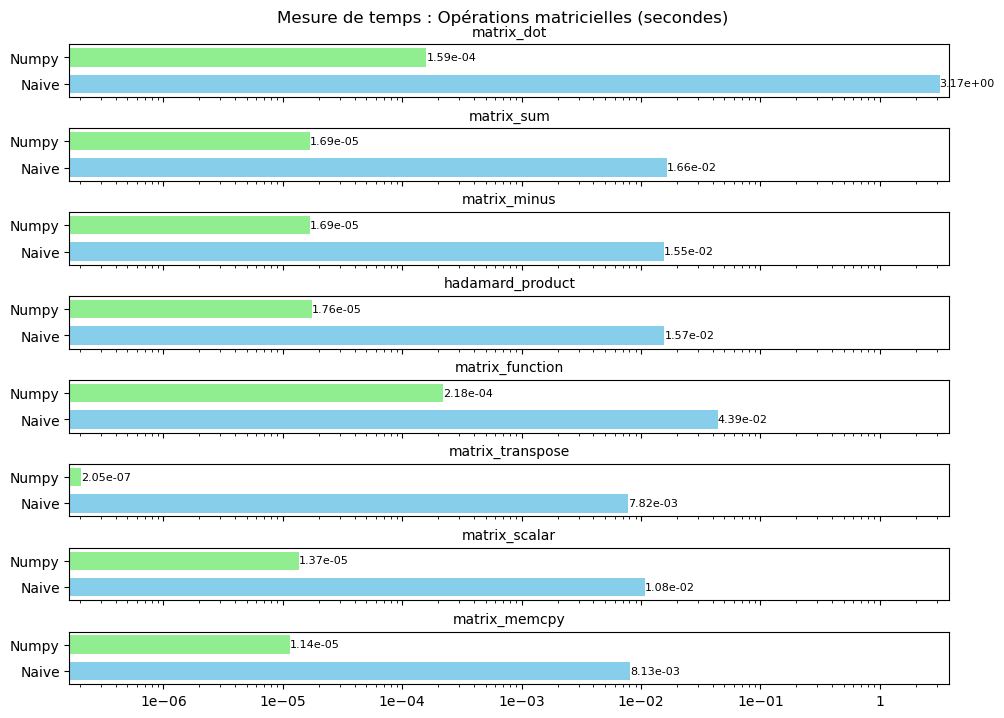

In [132]:
def plot_results_timeit(results, title):
    
    pairs = []
    for key, val in results.items():
        if 'naive' in key:
            numpy_key = key.replace('naive', 'numpy')
            if numpy_key in results:
                pairs.append((key.replace('_naive', ''), val.best, results[numpy_key].best))
                
    n_plots = len(pairs)
    fig, axes = plt.subplots(n_plots, 1, figsize=(10, n_plots * 0.9), sharex=True)
    if n_plots == 1:
        axes = [axes]
    global_min = min(min(naive, numpy) for _, naive, numpy in pairs)
    global_max = max(max(naive, numpy) for _, naive, numpy in pairs)
    
    for ax, (operation, naive_val, numpy_val) in zip(axes, pairs):
        y_positions = [1.95, 2.05]
        bar_height = 0.07
        ax.barh(y_positions, [naive_val, numpy_val], color=['skyblue', 'lightgreen'], height=bar_height)
        ax.set_title(operation, fontsize=10)
        ax.set_xscale('log')
        lower_limit = max(global_min * 0.8, 1e-12)
        ax.set_xlim(lower_limit, global_max * 1.2)
        ax.xaxis.set_major_locator(mticker.LogLocator(base=10.0))
        ax.xaxis.set_major_formatter(mticker.LogFormatter(base=10.0, labelOnlyBase=False))
        ax.set_ylim(1.9, 2.1)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(['Naive', 'Numpy'])

        for pos, val in zip(y_positions, [naive_val, numpy_val]):
            ax.text(val, pos, f'{val:.2e}', va='center', ha='left', color='black', fontsize=8)

    plt.suptitle(title, fontsize=12)
    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
    plt.show()

plot_results_timeit(results_time, "Mesure de temps : Opérations matricielles (secondes)")

### 6.1. Mesures individuelles de la mémoire

In [119]:
A_800 = np.random.rand(800, 800)
B_800 = np.random.rand(800, 800)
A_800_naive = alloc_matrix(800, 800)
B_800_naive = alloc_matrix(800, 800)
matrix_memcpy_numpy(A_800_naive, A_800)
matrix_memcpy_numpy(B_800_naive, B_800)

all_functions_800 = {
    "matrix_dot_naive":       lambda: matrix_dot_naive(A_800_naive, B_800_naive),
    "matrix_dot_numpy":       lambda: matrix_dot_numpy(A_800, B_800),
    "matrix_sum_naive":       lambda: matrix_sum_naive(A_800_naive, B_800_naive),
    "matrix_sum_numpy":       lambda: matrix_sum_numpy(A_800, B_800),
    "matrix_minus_naive":     lambda: matrix_minus_naive(A_800_naive, B_800_naive),
    "matrix_minus_numpy":     lambda: matrix_minus_numpy(A_800, B_800),
    "hadamard_product_naive": lambda: hadamard_product_naive(A_800_naive, B_800_naive),
    "hadamard_product_numpy": lambda: hadamard_product_numpy(A_800, B_800),
    "matrix_function_naive":  lambda: matrix_function_naive(A_800_naive, np.exp),
    "matrix_function_numpy":  lambda: matrix_function_numpy(A_800, np.exp),
    "matrix_transpose_naive": lambda: matrix_transpose_naive(A_800_naive),
    "matrix_transpose_numpy": lambda: matrix_transpose_numpy(A_800),
    "matrix_scalar_naive":    lambda: matrix_scalar_naive(A_800_naive, 1.5),
    "matrix_scalar_numpy":    lambda: matrix_scalar_numpy(A_800, 1.5),
    "matrix_memcpy_naive":    lambda: matrix_memcpy_naive(A_800_naive, B_800_naive),
    "matrix_memcpy_numpy":    lambda: matrix_memcpy_numpy(A_800_naive, B_800),
}

In [101]:
results_memory = {}
for func_name, func_call in all_functions_800.items():
    print(f"\n=== {func_name} ===")
    memory_result = get_ipython().run_line_magic('memit', '-o func_call()')
    results_memory[func_name] = memory_result


=== matrix_dot_naive ===
peak memory: 381.27 MiB, increment: 4.89 MiB

=== matrix_dot_numpy ===
peak memory: 376.39 MiB, increment: 0.00 MiB

=== matrix_sum_naive ===
peak memory: 380.55 MiB, increment: 4.16 MiB

=== matrix_sum_numpy ===
peak memory: 376.39 MiB, increment: 0.00 MiB

=== matrix_minus_naive ===
peak memory: 380.32 MiB, increment: 3.93 MiB

=== matrix_minus_numpy ===
peak memory: 376.40 MiB, increment: 0.00 MiB

=== hadamard_product_naive ===
peak memory: 380.28 MiB, increment: 3.88 MiB

=== hadamard_product_numpy ===
peak memory: 376.40 MiB, increment: 0.00 MiB

=== matrix_function_naive ===
peak memory: 380.85 MiB, increment: 4.45 MiB

=== matrix_function_numpy ===
peak memory: 376.40 MiB, increment: 0.00 MiB

=== matrix_transpose_naive ===
peak memory: 381.32 MiB, increment: 4.92 MiB

=== matrix_transpose_numpy ===
peak memory: 376.44 MiB, increment: 0.00 MiB

=== matrix_scalar_naive ===
peak memory: 379.11 MiB, increment: 2.67 MiB

=== matrix_scalar_numpy ===
peak me

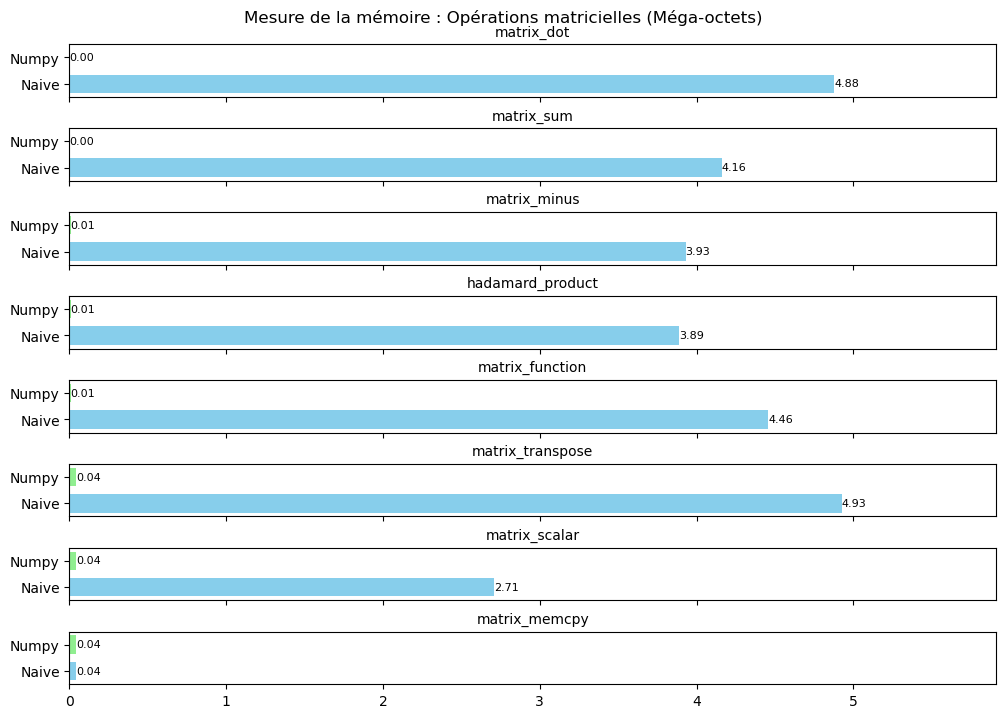

In [151]:
def plot_results_memit(results, title):
    
    pairs = []
    for key, val in results.items():
        if 'naive' in key:
            numpy_key = key.replace('naive', 'numpy')
            if numpy_key in results:
                pairs.append((key.replace('_naive', ''), val.mem_usage[0], results[numpy_key].mem_usage[0]))
                
    n_plots = len(pairs)
    fig, axes = plt.subplots(n_plots, 1, figsize=(10, n_plots * 0.9), sharex=True)
    if n_plots == 1:
        axes = [axes]
    
    global_min = min(min(naive, numpy) for _, naive, numpy in pairs)
    global_max = max(max(naive, numpy) for _, naive, numpy in pairs)
    
    for ax, (operation, naive_val, numpy_val) in zip(axes, pairs):
        naive_val -= global_min
        numpy_val -= global_min
        y_positions = [1.95, 2.05]
        bar_height = 0.07
        ax.barh(y_positions, [naive_val, numpy_val], color=['skyblue', 'lightgreen'], height=bar_height)
        ax.set_title(operation, fontsize=10)
        ax.set_xlim(0, (global_max - global_min) * 1.2)
        ax.set_ylim(1.9, 2.1)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(['Naive', 'Numpy'])

        for pos, val in zip(y_positions, [naive_val, numpy_val]):
            ax.text(val, pos, f'{val:.2f}', va='center', ha='left', color='black', fontsize=8)

    plt.suptitle(title, fontsize=12)
    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
    plt.show()

plot_results_memit(results_memory, "Mesure de la mémoire : Opérations matricielles (Méga-octets)")

### 6.3. Mesures de performances

In [172]:
alpha = 0.05
minibatch_size = 16
number_of_layers = 3
nneurons_per_layer = [784, 30, 10]  # 28*28 = 784
nn = ANN(alpha, minibatch_size, number_of_layers, nneurons_per_layer)

shuffled_idx = zero_to_n(train_size)
x = alloc_matrix(784, minibatch_size)
y = alloc_matrix(10, minibatch_size)

def test_epoch_numpy(nn, train_img, train_label, batch_size=16, max_samples=1000):
    shuffle(shuffled_idx, train_size)
    nbatches = min((train_size // batch_size) * batch_size, max_samples)
    batch_iter = range(0, nbatches, batch_size)
    ce_total = 0.0
    n_train_batches = 0
    acc = accuracy_numpy(nn, test_img, test_label, batch_size)
    desc = f'Acc: {acc:.2f}%'
    for i in tqdm(batch_iter, desc=desc):
        batch_indices = shuffled_idx[i : i + batch_size]
        populate_numpy(x, y, batch_indices, train_img, train_label)
        set_input(nn, x)
        forward(nn, sigmoid)
        y_pred = nn.layers[-1].activations  
        ce_batch = cross_entropy_numpy(y_pred, y)
        ce_total += ce_batch
        n_train_batches += 1
        backward(nn, y, dsigmoid)
    ce_mean = ce_total / n_train_batches
    acc = accuracy_numpy(nn, test_img, test_label, batch_size)
    desc = f'Acc: {acc:.2f}%, CE: {ce_mean:.4f}'
    return nbatches

def test_epoch_naive(nn, train_img, train_label, batch_size=16, max_samples=1000):
    shuffle(shuffled_idx, train_size)
    nbatches = min((train_size // batch_size) * batch_size, max_samples)
    batch_iter = range(0, nbatches, batch_size)
    ce_total = 0.0
    n_train_batches = 0
    acc = accuracy_naive(nn, test_img, test_label, batch_size)
    desc = f'Acc: {acc:.2f}%'
    for i in tqdm(batch_iter, desc=desc):
        batch_indices = shuffled_idx[i : i + batch_size]
        populate_naive(x, y, batch_indices, train_img, train_label)
        set_input(nn, x)
        forward(nn, sigmoid)
        y_pred = nn.layers[-1].activations  
        ce_batch = cross_entropy_naive(y_pred, y)
        ce_total += ce_batch
        n_train_batches += 1
        backward(nn, y, dsigmoid)
    ce_mean = ce_total / n_train_batches
    acc = accuracy_naive(nn, test_img, test_label, batch_size)
    desc = f'Acc: {acc:.2f}%, CE: {ce_mean:.4f}'
    return nbatches

In [180]:
get_ipython().run_line_magic('lprun', '-f test_epoch_naive test_epoch_naive(nn, train_img, train_label, 16, 5000)')

Acc: 87.98%: 100%|██████████| 313/313 [00:14<00:00, 21.30it/s]


Timer unit: 1e-07 s

Total time: 74.6089 s
File: C:\Users\sacha\AppData\Local\Temp\ipykernel_9220\2481588105.py
Function: test_epoch_naive at line 34

Line #      Hits         Time  Per Hit   % Time  Line Contents
    34                                           def test_epoch_naive(nn, train_img, train_label, batch_size=16, max_samples=1000):
    35         1    4798235.0    5e+06      0.6      shuffle(shuffled_idx, train_size)
    36         1         31.0     31.0      0.0      nbatches = min((train_size // batch_size) * batch_size, max_samples)
    37         1         18.0     18.0      0.0      batch_iter = range(0, nbatches, batch_size)
    38         1          5.0      5.0      0.0      ce_total = 0.0
    39         1          3.0      3.0      0.0      n_train_batches = 0
    40         1  293089169.0    3e+08     39.3      acc = accuracy_naive(nn, test_img, test_label, batch_size)
    41         1         68.0     68.0      0.0      desc = f'Acc: {acc:.2f}%'
    42       314

In [179]:
get_ipython().run_line_magic('lprun', '-f test_epoch_numpy test_epoch_numpy(nn, train_img, train_label, 16, 50000)')

Acc: 82.73%: 100%|██████████| 3125/3125 [00:01<00:00, 2081.58it/s]


Timer unit: 1e-07 s

Total time: 2.20499 s
File: C:\Users\sacha\AppData\Local\Temp\ipykernel_9220\2481588105.py
Function: test_epoch_numpy at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           def test_epoch_numpy(nn, train_img, train_label, batch_size=16, max_samples=1000):
    12         1    4560146.0    5e+06     20.7      shuffle(shuffled_idx, train_size)
    13         1         30.0     30.0      0.0      nbatches = min((train_size // batch_size) * batch_size, max_samples)
    14         1         17.0     17.0      0.0      batch_iter = range(0, nbatches, batch_size)
    15         1          5.0      5.0      0.0      ce_total = 0.0
    16         1          2.0      2.0      0.0      n_train_batches = 0
    17         1    1521706.0    2e+06      6.9      acc = accuracy_numpy(nn, test_img, test_label, batch_size)
    18         1        103.0    103.0      0.0      desc = f'Acc: {acc:.2f}%'
    19      3126

### 6.4. Entraînement du réseau

In [50]:
# REMPLACER NUMPY (_numpy) PAR NAIVE (_numpy) UNIQUEMENT DANS CE BLOC

NEPOCHS = 5

for epoch in range(NEPOCHS):
    shuffle(shuffled_idx, train_size)
    nbatches = (train_size // minibatch_size) * minibatch_size
    batch_iter = range(0, nbatches, minibatch_size)
    ce_total = 0.0
    n_train_batches = 0
    acc = accuracy_numpy(nn, test_img, test_label, minibatch_size)
    desc = f'Epoch {epoch} - Acc: {acc:.2f}%'
    for i in tqdm(batch_iter, desc=desc):
        batch_indices = shuffled_idx[i : i + minibatch_size]
        populate_numpy(x, y, batch_indices, train_img, train_label)
        set_input(nn, x)
        forward(nn, sigmoid)
        y_pred = nn.layers[-1].activations  
        ce_batch = cross_entropy_numpy(y_pred, y)
        ce_total += ce_batch
        n_train_batches += 1
        backward(nn, y, dsigmoid)
    ce_mean = ce_total / n_train_batches
    acc = accuracy_numpy(nn, test_img, test_label, minibatch_size)
    desc = f'Epoch {epoch} - Acc: {acc:.2f}%, CE: {ce_mean:.4f}'

acc_end = accuracy_numpy(nn, test_img, test_label, minibatch_size)
ce_end = cross_entropy_numpy(y_pred, y)
print("Final Model : Accuracy = {:.2f}%, Cross-Entropy Error = {:.4f}".format(acc_end, ce_end))

Epoch 0 - Acc: 8.92%:  50%|█████     | 1885/3750 [00:00<00:00, 3547.87it/s]


KeyboardInterrupt: 